# Evaluate gridworld agents

In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src.tabular.discrete_agent import DiscreteAgent
from src.env.gridworld import Gridworld
from src.visualization.gridworld import GridworldVis
from src.tabular.gridworld_experiment import load_ground_truth_agent
from src.tabular.gridworld_experiment import create_experiment
from src.tabular.utils import rollout
from src.tabular.utils import kl_divergence

In [2]:
def load_trained_agent(path):
    # load args
    with open(os.path.join(path, "args.json"), "rb") as f:
        arglist = json.load(f)

    # load state dict
    state_dict = torch.load(os.path.join(path, "model.pt"))
    agent_state_dict = {
        k.replace("agent.", ""): v for (k, v) in state_dict["model_state_dict"].items() if "agent." in k
    }
    
    state_dim = int(arglist["num_grids"] ** 2)
    act_dim = 5
    gamma = arglist["gamma"]
    alpha = arglist["alpha"]
    horizon = arglist["horizon"]
    agent = DiscreteAgent(state_dim, act_dim, gamma, alpha, horizon)

    agent.load_state_dict(agent_state_dict)
    agent.plan()
    return agent

In [3]:
# load ground truth agents
num_grids = 5
true_agent = load_ground_truth_agent(
    num_grids, "one_state", "one_goal", 1.
)

In [22]:
# load btom agents
exp_path = "../exp/gridworld/btom"

# benchmark agent
btom_agent_1 = load_trained_agent(
    os.path.join(exp_path, "one_state_one_goal", "04-17-2023 11-10-28")
)

# lambda = 0.001
btom_agent_2 = load_trained_agent(
    os.path.join(exp_path, "one_state_one_goal", "04-17-2023 13-08-27")
)

# lambda = 0.5
btom_agent_3 = load_trained_agent(
    os.path.join(exp_path, "one_state_one_goal", "04-17-2023 13-50-08")
)

# lambda = 10
btom_agent_4 = load_trained_agent(
    os.path.join(exp_path, "one_state_one_goal", "04-17-2023 11-34-33")
)

In [5]:
# init visualizer
vis = GridworldVis(Gridworld(num_grids))

## Eval reward, value, and policy

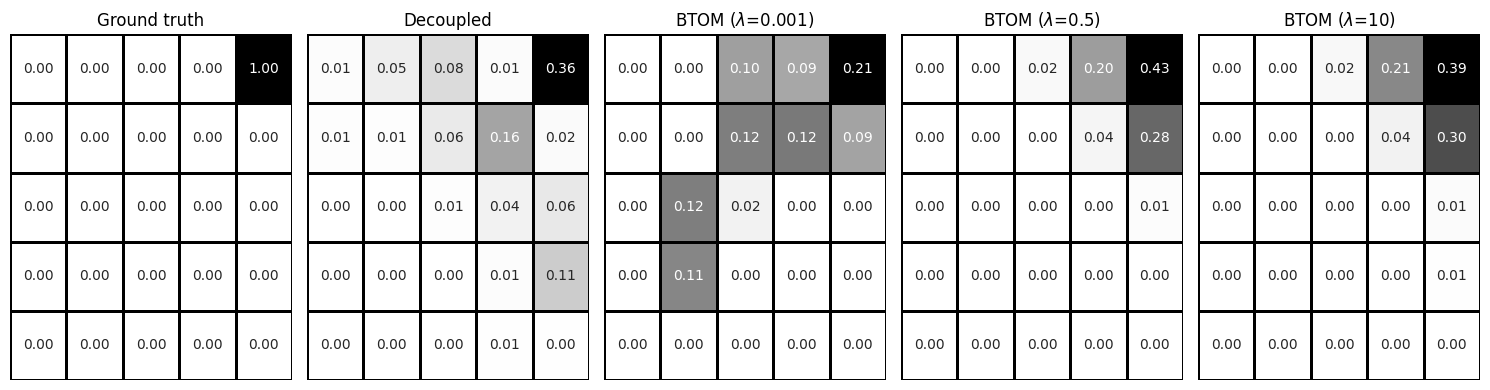

In [94]:
# plot rewards
cmap = "Greys"
fig, ax = plt.subplots(1, 5, figsize=(15, 4))

# plot trained agents
vis.plot_value_map(torch.softmax(true_agent.log_target, dim=-1).data, ax[0], cmap=cmap)
vis.plot_value_map(torch.softmax(btom_agent_1.log_target, dim=-1).data, ax[1], cmap=cmap)
vis.plot_value_map(torch.softmax(btom_agent_2.log_target, dim=-1).data, ax[2], cmap=cmap)
vis.plot_value_map(torch.softmax(btom_agent_3.log_target, dim=-1).data, ax[3], cmap=cmap)
vis.plot_value_map(torch.softmax(btom_agent_4.log_target, dim=-1).data, ax[4], cmap=cmap)

ax[0].set_title("Ground truth")
ax[1].set_title("Decoupled")
ax[2].set_title(r"BTOM ($\lambda$=0.001)")
ax[3].set_title(r"BTOM ($\lambda$=0.5)")
ax[4].set_title(r"BTOM ($\lambda$=10)")

for i in range(5):
    ax[i].axis("off")

plt.tight_layout()
plt.show()

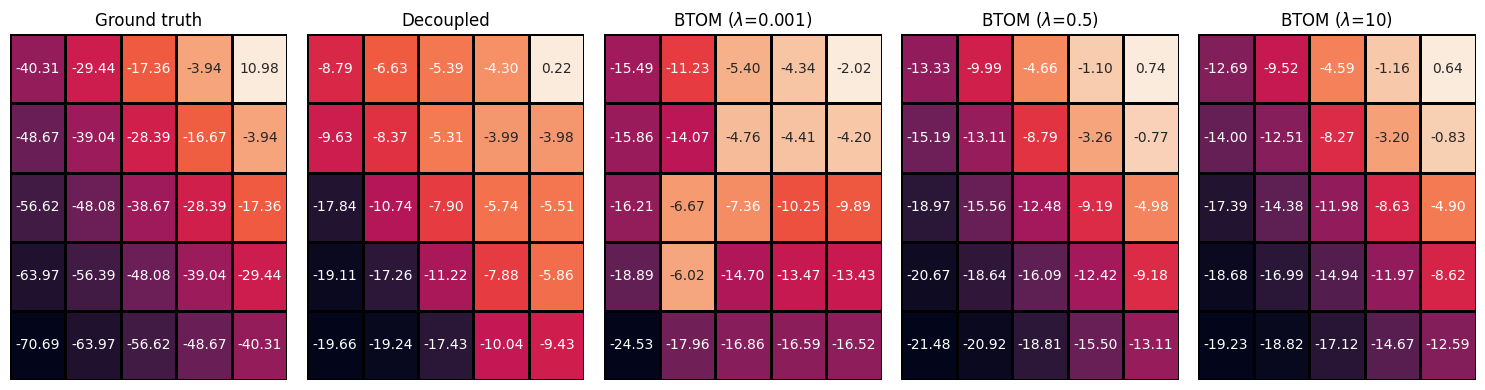

In [52]:
# plot values
fig, ax = plt.subplots(1, 5, figsize=(15, 4))

# plot trained agents
vis.plot_value_map(true_agent.v, ax[0])
vis.plot_value_map(btom_agent_1.v, ax[1])
vis.plot_value_map(btom_agent_2.v, ax[2])
vis.plot_value_map(btom_agent_3.v, ax[3])
vis.plot_value_map(btom_agent_4.v, ax[4])

ax[0].set_title("Ground truth")
ax[1].set_title("Decoupled")
ax[2].set_title(r"BTOM ($\lambda$=0.001)")
ax[3].set_title(r"BTOM ($\lambda$=0.5)")
ax[4].set_title(r"BTOM ($\lambda$=10)")

for i in range(5):
    ax[i].axis("off")

plt.tight_layout()
plt.show()

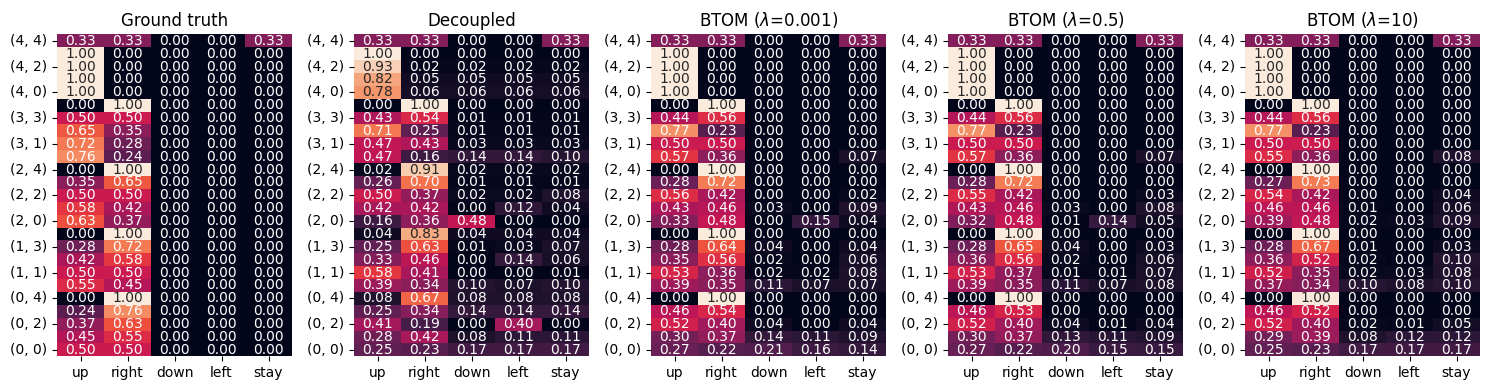

In [53]:
# plot policies
fig, ax = plt.subplots(1, 5, figsize=(15, 4))

# plot trained agents
vis.plot_state_action(true_agent.pi, ax[0])
vis.plot_state_action(btom_agent_1.pi, ax[1])
vis.plot_state_action(btom_agent_2.pi, ax[2])
vis.plot_state_action(btom_agent_3.pi, ax[3])
vis.plot_state_action(btom_agent_4.pi, ax[4])

ax[0].set_title("Ground truth")
ax[1].set_title("Decoupled")
ax[2].set_title(r"BTOM ($\lambda$=0.001)")
ax[3].set_title(r"BTOM ($\lambda$=0.5)")
ax[4].set_title(r"BTOM ($\lambda$=10)")

plt.tight_layout()
plt.show()

In [61]:
print("agent 1 kl", kl_divergence(true_agent.pi, btom_agent_1.pi).mean().data.item())
print("agent 2 kl", kl_divergence(true_agent.pi, btom_agent_2.pi).mean().data.item())
print("agent 3 kl", kl_divergence(true_agent.pi, btom_agent_3.pi).mean().data.item())
print("agent 4 kl", kl_divergence(true_agent.pi, btom_agent_4.pi).mean().data.item())

agent 1 kl 0.25204911828041077
agent 2 kl 0.10769157111644745
agent 3 kl 0.10765603184700012
agent 4 kl 0.10707329958677292


## Eval learned dynamics

In [48]:
def plot_transition_row(transition, ax, model_name, a_labels, vmin=0., vmax=1., cmap="Greys"):
    for i in range(len(transition)):
        sns.heatmap(
            transition[i], vmin=vmin, vmax=vmax, annot=False, cbar=False, cmap=cmap, ax=ax[i]
        )
        ax[i].set_title(f"{model_name}, a={a_labels[i]}")

def plot_transitions(transitions, model_names, s_labels, a_labels, ax):
    for i, transition in enumerate(transitions):
        plot_transition_row(transition, ax[i, :], model_names[i], a_labels)
    
    for i in range(len(a_labels)):
        ax[-1, i].set_xticklabels(
            [tuple(s_labels[int(l - 0.5)]) for l in ax[0, 0].get_xticks()],
            rotation=45
        )
        ax[-1, i].set_xlabel("Next state")

    for j in range(len(ax)):
        ax[j, 0].set_yticklabels(
            [tuple(s_labels[int(l - 0.5)]) for l in ax[0, 0].get_yticks()],
            rotation=0
        )
        ax[j, 0].set_ylabel("State")

    plt.tight_layout()

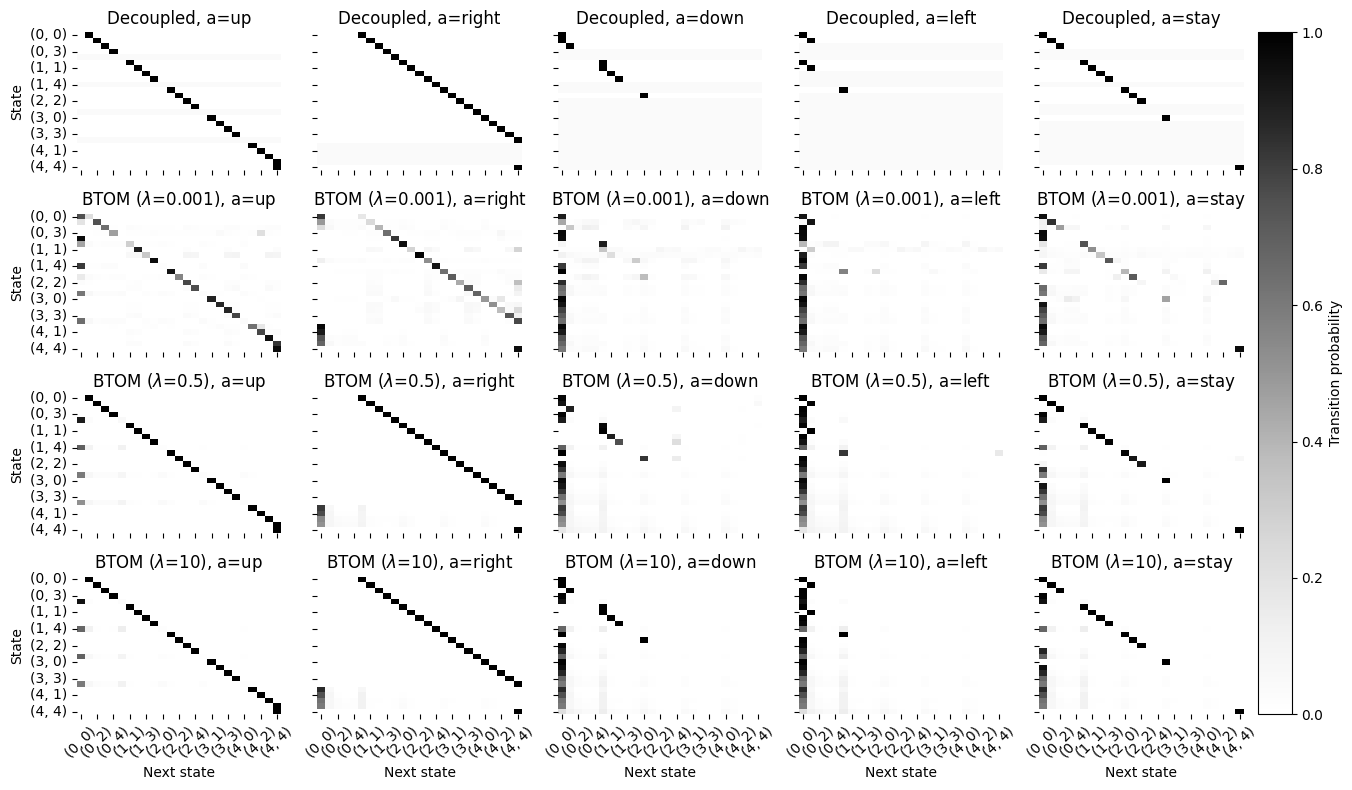

In [50]:
env = Gridworld(num_grids)

fig, ax = plt.subplots(4, true_agent.act_dim, figsize=(15, 8), sharex=True, sharey=True)
plot_transitions(
    [
        btom_agent_1.transition().data.numpy(), 
        btom_agent_2.transition().data.numpy(),
        btom_agent_3.transition().data.numpy(),
        btom_agent_4.transition().data.numpy(),
    ],
    [
        "Decoupled", 
        r"BTOM ($\lambda$=0.001)",
        r"BTOM ($\lambda$=0.5)",
        r"BTOM ($\lambda$=10)"
    ], 
    env.state2pos, env.a_labels, ax
)
fig.colorbar(
    ax[-1, -1].collections[0], ax=ax.ravel().tolist(), pad=0.01, label="Transition probability"
)
plt.show()

## Simulate agent

In [6]:
num_grids = 5
init_type = "one_state"
goal_type = "one_goal"
init_specs, goal_specs = create_experiment(
    num_grids, init_type, goal_type
)

In [38]:
def collect_sample_path(agent, num_traj, max_steps=50):
    """ Collect sample path in estimated dynamics """
    env = Gridworld(
        num_grids, init_specs, goal_specs
    )
    env.transition_matrix = agent.transition().data.numpy()
    # env.transition_matrix = env.transition_matrix.round(4)
    # env.transition_matrix /= env.transition_matrix.sum(-1, keepdims=True)

    data = []
    for i in range(num_traj):
        data.append(rollout(env, agent, max_steps=max_steps))
    s_seq = np.stack([d["s"] for d in data])
    return s_seq

In [39]:
np.random.seed(0)
torch.manual_seed(0)
num_traj = 100
sample_path_0 = collect_sample_path(true_agent, num_traj)
sample_path_1 = collect_sample_path(btom_agent_1, num_traj)
sample_path_2 = collect_sample_path(btom_agent_2, num_traj)
sample_path_3 = collect_sample_path(btom_agent_3, num_traj)
sample_path_4 = collect_sample_path(btom_agent_4, num_traj)

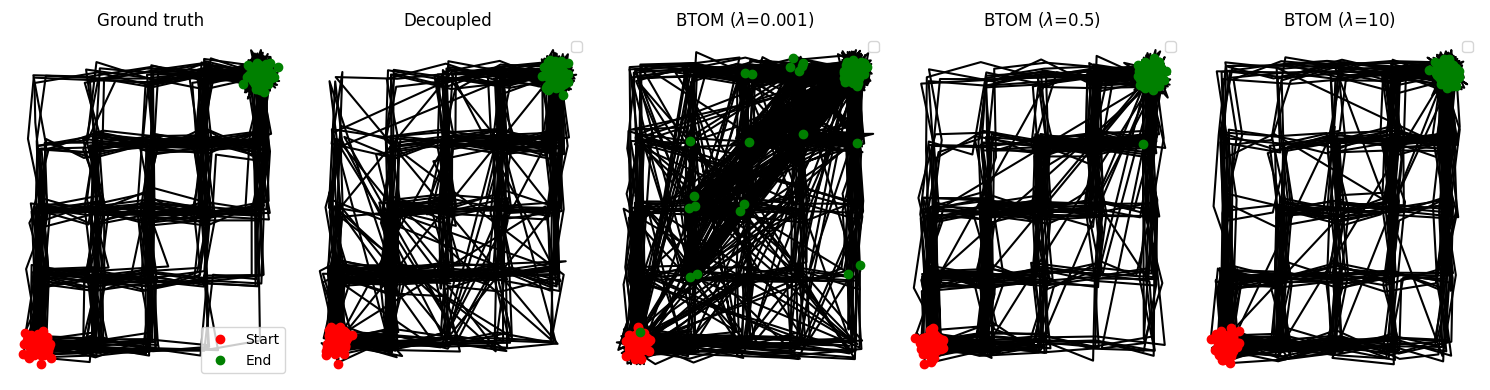

In [40]:
eps = 0.1
fig, ax = plt.subplots(1, 5, figsize=(15, 4))
vis.plot_sample_path(sample_path_0, ax[0], eps=eps)
vis.plot_sample_path(sample_path_1, ax[1], eps=eps)
vis.plot_sample_path(sample_path_2, ax[2], eps=eps)
vis.plot_sample_path(sample_path_3, ax[3], eps=eps)
vis.plot_sample_path(sample_path_4, ax[4], eps=eps)

ax[0].set_title("Ground truth")
ax[1].set_title("Decoupled")
ax[2].set_title(r"BTOM ($\lambda$=0.001)")
ax[3].set_title(r"BTOM ($\lambda$=0.5)")
ax[4].set_title(r"BTOM ($\lambda$=10)")

for i in range(5):
    ax[i].axis("off")
    if i != 0:
        ax[i].legend("")

plt.tight_layout()
plt.show()

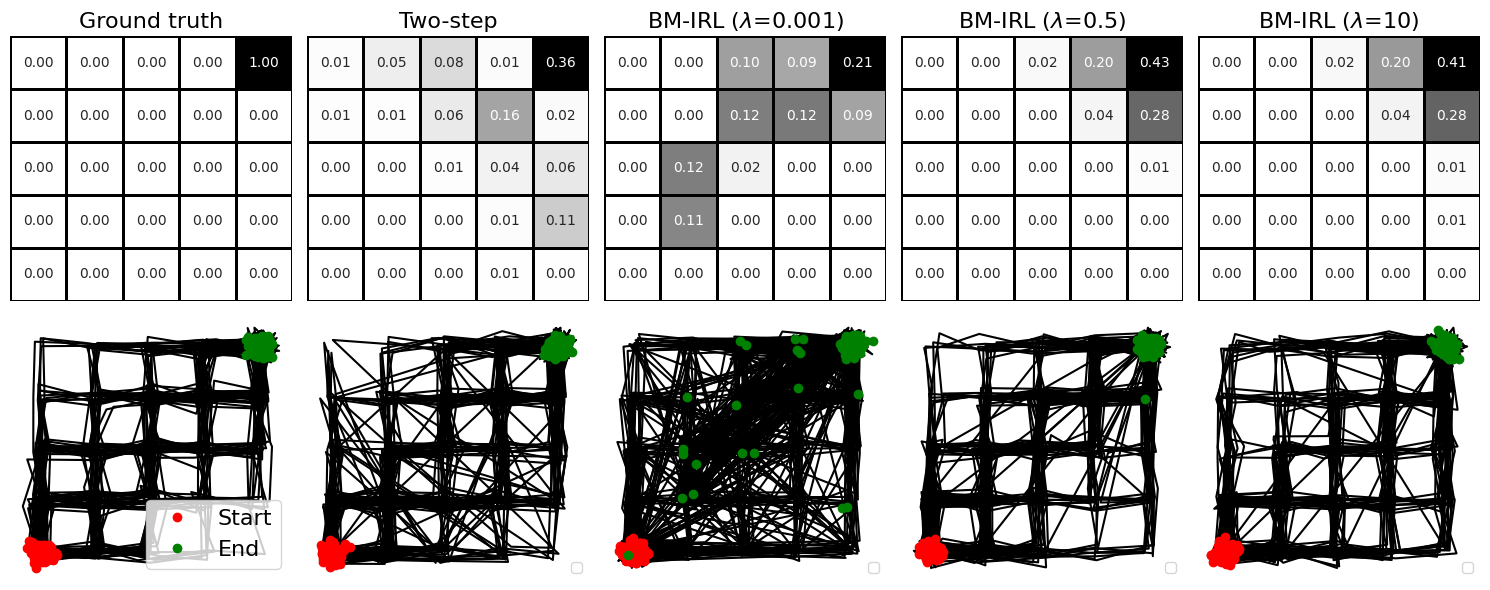

In [41]:
# pretty plot
title_fontsize = 16
cmap = "Greys"
fig, ax = plt.subplots(2, 5, figsize=(15, 6))

# plot reward
vis.plot_value_map(torch.softmax(true_agent.log_target, dim=-1).data, ax[0, 0], cmap=cmap)
vis.plot_value_map(torch.softmax(btom_agent_1.log_target, dim=-1).data, ax[0, 1], cmap=cmap)
vis.plot_value_map(torch.softmax(btom_agent_2.log_target, dim=-1).data, ax[0, 2], cmap=cmap)
vis.plot_value_map(torch.softmax(btom_agent_3.log_target, dim=-1).data, ax[0, 3], cmap=cmap)
vis.plot_value_map(torch.softmax(btom_agent_4.log_target, dim=-1).data, ax[0, 4], cmap=cmap)

ax[0, 0].set_title("Ground truth", fontsize=title_fontsize)
ax[0, 1].set_title("Two-step", fontsize=title_fontsize)
ax[0, 2].set_title(r"BM-IRL ($\lambda$=0.001)", fontsize=title_fontsize)
ax[0, 3].set_title(r"BM-IRL ($\lambda$=0.5)", fontsize=title_fontsize)
ax[0, 4].set_title(r"BM-IRL ($\lambda$=10)", fontsize=title_fontsize)

# plot sample path
vis.plot_sample_path(sample_path_0, ax[1, 0])
vis.plot_sample_path(sample_path_1, ax[1, 1])
vis.plot_sample_path(sample_path_2, ax[1, 2])
vis.plot_sample_path(sample_path_3, ax[1, 3])
vis.plot_sample_path(sample_path_4, ax[1, 4])

for i in range(5):
    ax[0, i].axis("off")
    ax[1, i].axis("off")

    if i != 0:
        ax[1, i].legend("", loc="lower right")
    else:
        ax[1, i].legend(loc="lower right", fontsize=16)

plt.tight_layout()
plt.show()

fig.savefig("../fig/gridworld.png", dpi=200)